In [ ]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score,mean_squared_error,precision_score,roc_auc_score, roc_curve, mean_absolute_error
#we don't need roc_auc_score, roc_curve, since they are for classifier model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#checking the file path
import os
file_path = '/content/drive/MyDrive/train_sup.csv'
print(os.path.exists(file_path))

True


In [ ]:
#uploading data
df1 = pd.read_csv('/content/drive/MyDrive/train_sup.csv')

In [ ]:
print(df1.head(3))

   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633 

In [ ]:
print(df1.columns)

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [ ]:
df1.isnull().sum()

,0
number_of_elements,0
mean_atomic_mass,0
wtd_mean_atomic_mass,0
gmean_atomic_mass,0
wtd_gmean_atomic_mass,0
...,...
range_Valence,0
wtd_range_Valence,0
std_Valence,0
wtd_std_Valence,0


In [ ]:
# # remove all columns that have very small correlation wtih target due to their low scatterness
# threshold=0.1 #this gets rid of features which are the same value 90% of the time
# from sklearn.feature_selection import VarianceThreshold
# selector = VarianceThreshold(threshold=threshold).fit(df1)
# data= pd.DataFrame(selector.transform(df1),columns=df1.columns[selector.get_support()])
# data.shape
#this function has no effect on this dataframe, we get the information of scatteredness only(can remove).
data=df1
data.shape

(21263, 82)

In [ ]:
#Now drop any correlated features
#we know our target variable is critical temperature.
correlation_matrix = data.corr()
mutually_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            if colname!='critical_temp':
                mutually_correlated_features.add(colname)
print(len(mutually_correlated_features))
data.drop(mutually_correlated_features,axis=1,inplace=True)
data.shape

38


(21263, 44)

In [ ]:
# correlation_threshhold = 0.1

# corr = pd.DataFrame(data.corr()['critical_temp'])
# corr['abs'] = np.abs(corr['critical_temp'])
# corr = corr.sort_values(by='abs',ascending=False).drop('abs',axis=1).dropna().reset_index()
# corr = corr.rename(columns={'index':'feature','critical_temp':'corr'}).loc[1:]

# low_correlated_features = list(corr[np.abs(corr['corr'])<=correlation_threshhold]['feature'])
# data.drop(low_correlated_features,axis=1,inplace=True)
# data.shape

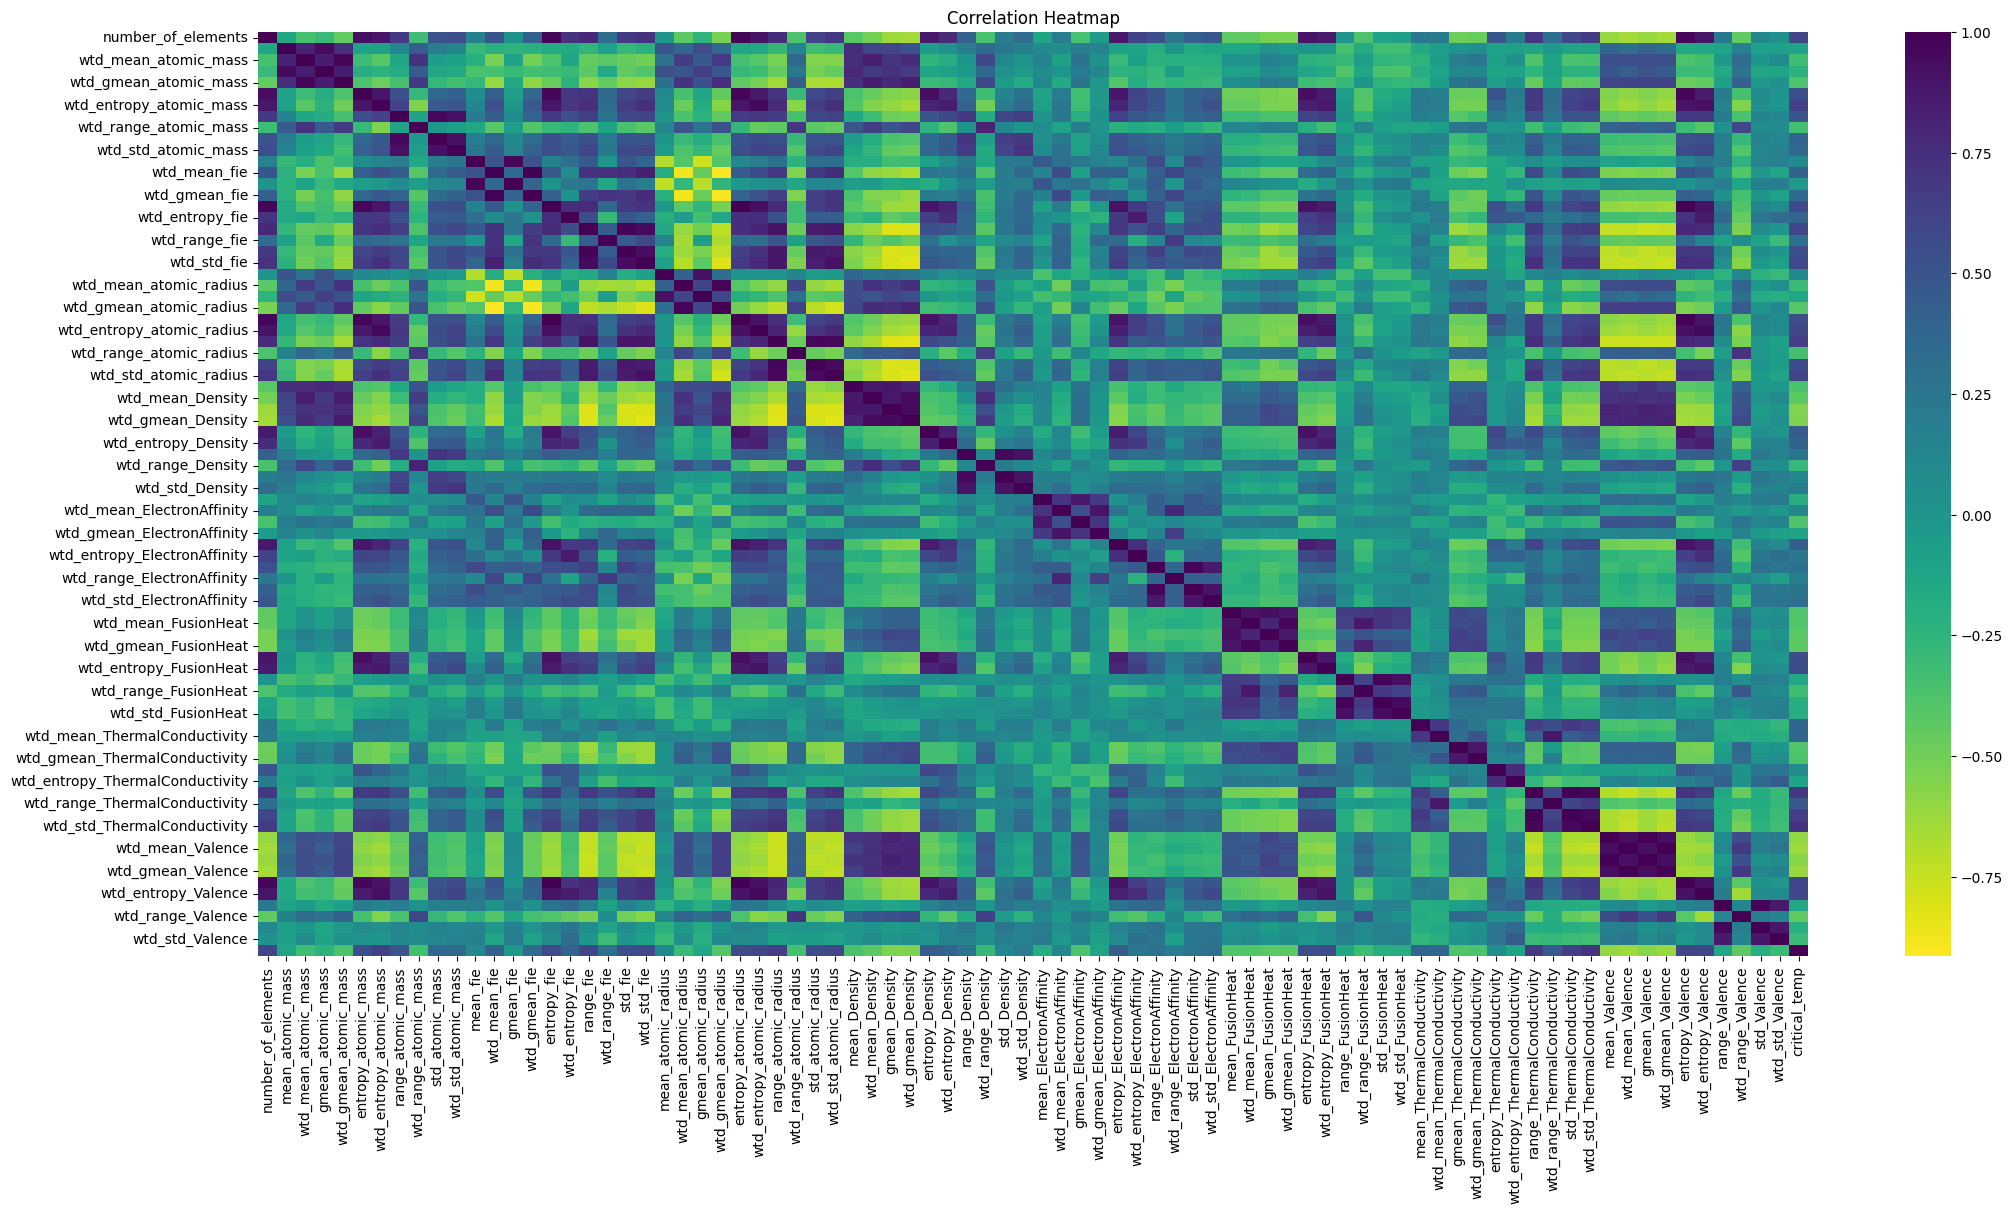

In [ ]:
# Create a heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(correlation_matrix, cmap='viridis_r', fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

It's pretty clear to find the correlation between target variable and dependent variables form the overall correlation heat map. Now for more clarification we use different code to find top five mostly correlated parameters.


In [ ]:
# getting the top five correlated variables in the dataframe
correlation_with_target = data.corr()['critical_temp'].abs().sort_values(ascending=False)

# Display the top five columns with the highest correlation
top_correlation_columns = correlation_with_target.index[1:6]  # Exclude the target column itself
top_correlation_values = correlation_with_target.iloc[1:6]

for col, value in zip(top_correlation_columns, top_correlation_values):
    print(f"Column: {col}, Correlation: {value:.2f}")

Column: range_ThermalConductivity, Correlation: 0.69
Column: wtd_entropy_atomic_mass, Correlation: 0.63
Column: number_of_elements, Correlation: 0.60
Column: range_fie, Correlation: 0.60
Column: mean_Valence, Correlation: 0.60


In [ ]:
import plotly.express as px
colors = px.colors.sequential.Viridis
fig = px.box(data, x="critical_temp", title="Box Plot of Critical Temperature", color_discrete_sequence=colors)
fig.update_layout(width=950, height=500, plot_bgcolor='lightgrey')
fig.show()

Data seems to be positively skewed.. we can compare the performance of different models by converting the data into normal distribution.

In [ ]:
# max_value= data['critical_temp'].max()
# # Step 3: Remove all rows with this maximum value
# df_filtered = data[data['critical_temp'] != max_value]

# # Step 4: Save the modified DataFrame to a new CSV file (optional)
# df_filtered.to_csv('filtered_data.csv', index=False)

In [ ]:
# df_filtered.isna().sum().sum()

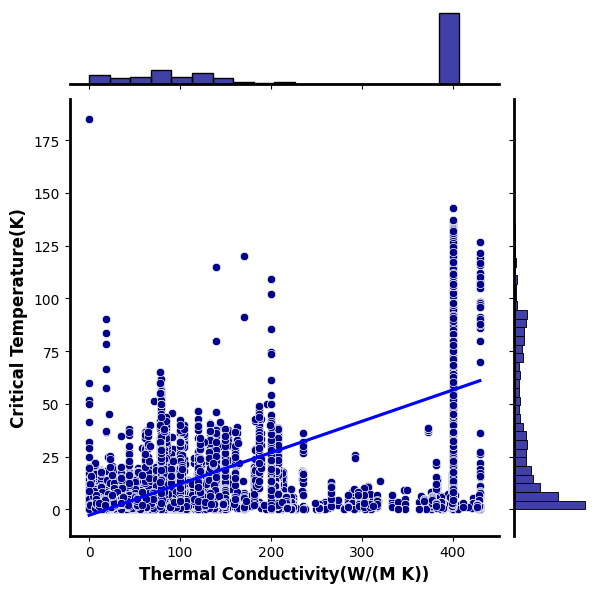

In [ ]:
#data visualization
joint_plot= sns.jointplot(x='range_ThermalConductivity', y='critical_temp', data=data, kind='scatter', marginal_kws=dict(color='#00008B'))

# # Customizing titles
# joint_plot.set_axis_labels('Range_thermalconductivity', 'Critical Temperature', fontsize=12)

# Changing plot color to deep blue (HEX color code: #00008B)
joint_plot.plot_joint(sns.scatterplot, color='#00008B')


# Adding best-fit line
sns.regplot(x='range_ThermalConductivity', y='critical_temp', data=data, scatter=False, ax=joint_plot.ax_joint, color='blue')
# Change the font of axis labels
joint_plot.ax_joint.set_xlabel('Thermal Conductivity(W/(M K))', fontsize=12, fontweight='bold')
joint_plot.ax_joint.set_ylabel('Critical Temperature(K)', fontsize=12, fontweight='bold')
# Adjust the thickness of the axis lines
for spine in joint_plot.ax_joint.spines.values():
    spine.set_linewidth(2)
# Adjust the thickness of the axis lines for the marginal plots
for spine in joint_plot.ax_marg_x.spines.values():
    spine.set_linewidth(2)
for spine in joint_plot.ax_marg_y.spines.values():
    spine.set_linewidth(2)

# # Save the image locally
plt.savefig('jointplot1.png', dpi=300)

plt.show()

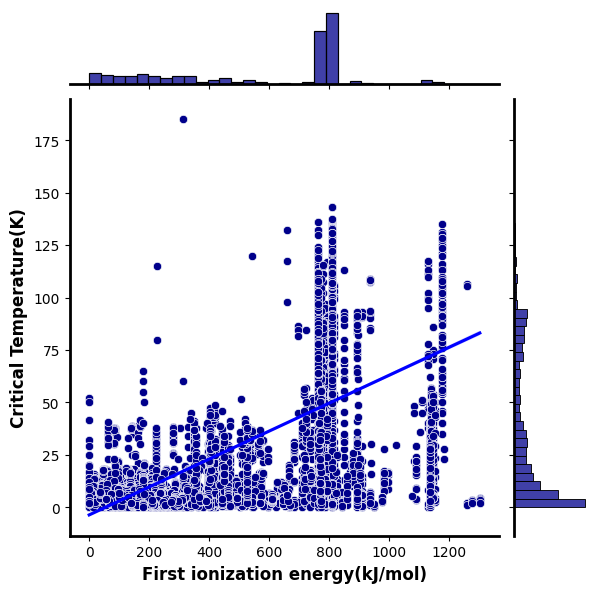

In [ ]:
#data visualization
joint_plot2=sns.jointplot(x='range_fie', y='critical_temp', data=data, kind='scatter', marginal_kws=dict(color='#00008B'))
# Customizing titles
joint_plot2.set_axis_labels('range_fie', 'Critical Temperature', fontsize=12)

# Changing plot color to deep blue (HEX color code: #00008B)
joint_plot2.plot_joint(sns.scatterplot, color='#00008B')



# Adding best-fit line
sns.regplot(x='range_fie', y='critical_temp', data=data, scatter=False, ax=joint_plot2.ax_joint, color='blue')
# Change the font of axis labels
joint_plot2.ax_joint.set_xlabel('First ionization energy(kJ/mol)', fontsize=12, fontweight='bold', fontfamily='Georgia')
joint_plot2.ax_joint.set_ylabel('Critical Temperature(K)', fontsize=12, fontweight='bold', fontfamily='Georgia')
# Adjust the thickness of the axis lines
for spine in joint_plot2.ax_joint.spines.values():
    spine.set_linewidth(2)
# Adjust the thickness of the axis lines for the marginal plots
for spine in joint_plot2.ax_marg_x.spines.values():
    spine.set_linewidth(2)
for spine in joint_plot2.ax_marg_y.spines.values():
    spine.set_linewidth(2)

# Save the image locally
plt.savefig('jointplot2.png', dpi=300)

plt.show()

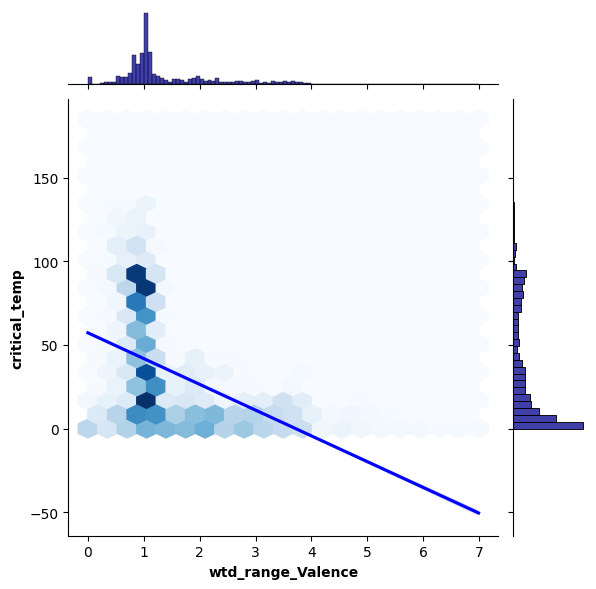

In [ ]:
joint_plot3= sns.jointplot(x='wtd_range_Valence', y='critical_temp', data=data, kind='hex', gridsize=20 , marginal_kws=dict(color='#00008B') , cmap='Blues')
# Customizing titles
joint_plot3.set_axis_labels('wtd_range_Valence', 'Critical Temperature', fontsize=12)

# Changing plot color to deep blue (HEX color code: #00008B)
#joint_plot3.plot_joint(sns.hexplot, color='#00008B')

# Change the font of axis labels
joint_plot3.ax_joint.set_xlabel('Range wtd Valence', fontsize=10, fontweight='bold', fontfamily='Georgia')
joint_plot3.ax_joint.set_ylabel('Critical Temperature', fontsize=10, fontweight='bold', fontfamily='Georgia')

# Adding best-fit line
sns.regplot(x='wtd_range_Valence', y='critical_temp', data=data, scatter=False, ax=joint_plot3.ax_joint, color='blue')

# Save the image locally
#plt.savefig('jointplot3up.png', dpi=300)

plt.show()

<Figure size 800x500 with 0 Axes>

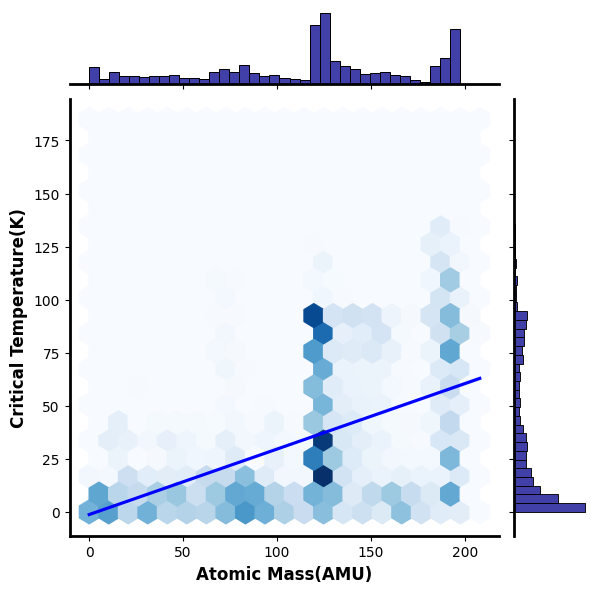

In [ ]:
plt.figure(figsize=(8, 5))
#sns.scatterplot(x='range_atomic_mass', y='critical_temp', data=data, , marginal_kws=dict(color='#00008B'))
joint_plot4= sns.jointplot(x='range_atomic_mass', y='critical_temp', data=data, kind='hex', gridsize=20 , marginal_kws=dict(color='#00008B') , cmap='Blues')
# Customizing titles
joint_plot4.set_axis_labels('range_atomic_mass', 'Critical Temperature', fontsize=12)

# Changing plot color to deep blue (HEX color code: #00008B)
#joint_plot3.plot_joint(sns.hexplot, color='#00008B')


# Adding best-fit line
sns.regplot(x='range_atomic_mass', y='critical_temp', data=data, scatter=False, ax=joint_plot4.ax_joint, color='blue')
# Change the font of axis labels
joint_plot4.ax_joint.set_xlabel('Atomic Mass(AMU)', fontsize=12, fontweight='bold', fontfamily='Georgia')
joint_plot4.ax_joint.set_ylabel('Critical Temperature(K)', fontsize=12, fontweight='bold', fontfamily='Georgia')

# Adjust the thickness of the axis lines
for spine in joint_plot4.ax_joint.spines.values():
    spine.set_linewidth(2)
# Adjust the thickness of the axis lines for the marginal plots
for spine in joint_plot4.ax_marg_x.spines.values():
    spine.set_linewidth(2)
for spine in joint_plot4.ax_marg_y.spines.values():
    spine.set_linewidth(2)

# Save the image locally
plt.savefig('jointplot4.png', dpi=300)

plt.show()

In [ ]:
target_variable = 'critical_temp'
X = data.drop(target_variable, axis=1)
y = data[target_variable]

# # Standardize(normalize) the features for same scale (important for PCA)
# X_standardized = (X - X.mean()) / X.std()

# # Apply PCA
# pca = PCA(n_components=X.shape[1])
# X_pca = pca.fit_transform(X_standardized)

# # Determine the number of components to retain based on explained variance
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = explained_variance_ratio.cumsum()

# # Choose the number of components that explain a certain percentage of the variance
# desired_explained_variance = 0.95  # Adjust as needed
# num_components_to_retain = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

# # Retain only the selected number of components
# X_pca_selected = X_pca[:, :num_components_to_retain]

# # Combine the selected components with the target variable
# data_pca = pd.DataFrame(data=X_pca_selected, columns=[f'PC{i}' for i in range(1, num_components_to_retain + 1)])
# data_pca[target_variable] = y

# # Your new DataFrame 'data_pca' contains the retained principal components and the target variable
# data_pca


In [ ]:
# data_pca.to_csv("filtered.csv")
# new_data = pd.read_csv('filtered.csv')
# new_data

In [ ]:

# X_dash = new_data.drop('critical_temp',axis=1)
# y_dash = new_data['critical_temp']
X_dash = X
y_dash = y

In [ ]:
#After using PCA(include scaling) it may not be necessary(optional)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X_dash)
print(type(scaled_X))
print(scaled_X.shape)

<class 'numpy.ndarray'>
(21263, 43)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_dash, test_size=0.3, random_state=42)

In [ ]:
y_train.isna().sum()

np.int64(0)

In [ ]:
y_train.fillna(y_train.mean(), inplace=True)

Best RMSE on test set: 9.6051
Best R² on test set: 0.9205


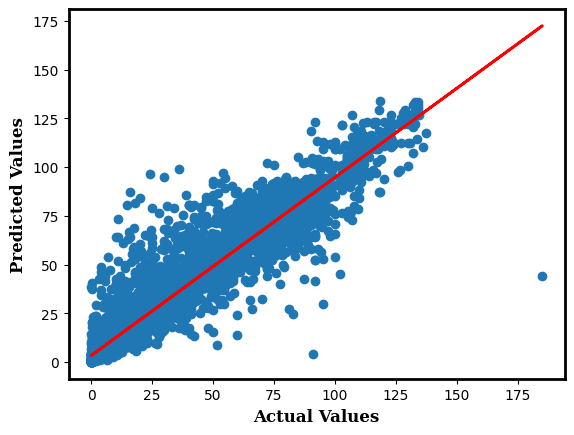

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Step 2: Define the Random Forest Regressor with best hyperparameters
best_params = {
    'n_estimators': 900,  # Number of trees
    'max_depth': 45,      # Maximum depth of trees
    'min_samples_split': 2,  # Minimum samples required to split a node
    'min_samples_leaf': 1,   # Minimum samples required at a leaf node
    'max_features': 'sqrt',  # Number of features to consider for the best split
    'random_state': 42,      # For reproducibility
}

# Step 3: Train the Random Forest Regressor
model_rf = RandomForestRegressor(**best_params)
model_rf.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model_rf.predict(X_test)

# Step 5: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the final results
print(f"Best RMSE on test set: {rmse:.4f}")
print(f"Best R² on test set: {r2:.4f}")


# Plotting actual vs predicted values
#plt.scatter(y_test, y_pred)
#plt.xlabel('Actual Values')
#plt.ylabel('Predicted Values')
#plt.title('Actual vs Predicted Values for Linear Regression')
#regression_line = np.polyfit(y_test, y_pred, 1)
#line = np.polyval(regression_line, y_test)
#plt.plot(y_test, line, color='red', linewidth=2)
#plt.show()

# Your code for plotting
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Predicted Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
#plt.title('Actual vs Predicted Values for Linear Regression', fontdict={'fontsize': 14, 'fontweight': 'bold', 'fontfamily': 'serif'})
regression_line = np.polyfit(y_test, y_pred, 1)
line = np.polyval(regression_line, y_test)
plt.plot(y_test, line, color='red', linewidth=2)
# Add figure name at the base
# plt.figtext(0.5, 0.01, 'Actual vs Predicted Values for Linear Regression', ha='center', fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Save the figure
plt.savefig('actual_vs_predicted_random_regressionp.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
|from sklearn.model_selection import cross_val_score

# Step 3: Optuna objective function for hyperparameter tuning
def objective(trial):
    # Hyperparameters to be optimized
    max_iter = trial.suggest_int('max_iter', 100, 1500)  # Increase iterations
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)  # Use log-uniform for alpha
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99)  # Fine range for l1_ratio

    # Model initialization and cross-validated training
    model = ElasticNet(max_iter=max_iter, alpha=alpha, l1_ratio=l1_ratio, random_state=42)

    # Use cross-validation instead of a simple train-test split
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Return the mean of the cross-validated negative MSE (Optuna will minimize it)
    return -scores.mean()

# Step 4: Perform hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Increase number of trials for better search

# Get the best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Step 5: Train the final ElasticNet model using best hyperparameters
best_model = ElasticNet(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Step 6: Evaluate the final model on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using RMSE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best RMSE on test set: {rmse:.4f}")
print(f"Best R² on test set: {r2:.4f}")

[I 2024-12-30 21:58:29,886] A new study created in memory with name: no-name-30a84297-869f-4dc5-95a1-591f5c5d3ef2
[I 2024-12-30 21:58:34,185] Trial 0 finished with value: 358.3485001502163 and parameters: {'max_iter': 345, 'alpha': 0.013805170096608605, 'l1_ratio': 0.4491031472311498}. Best is trial 0 with value: 358.3485001502163.
[I 2024-12-30 21:58:36,448] Trial 1 finished with value: 357.5472311344997 and parameters: {'max_iter': 938, 'alpha': 0.0058057649982438345, 'l1_ratio': 0.07624023563868118}. Best is trial 1 with value: 357.5472311344997.
[I 2024-12-30 21:58:39,576] Trial 2 finished with value: 356.776770760557 and parameters: {'max_iter': 885, 'alpha': 0.00039794248609692376, 'l1_ratio': 0.11775774184348647}. Best is trial 2 with value: 356.776770760557.
[I 2024-12-30 21:58:40,560] Trial 3 finished with value: 380.26599924923113 and parameters: {'max_iter': 1087, 'alpha': 0.09666908297265259, 'l1_ratio': 0.15412385126940267}. Best is trial 2 with value: 356.776770760557.
[I

Best Hyperparameters: {'max_iter': 754, 'alpha': 0.0007501708597386283, 'l1_ratio': 0.0393455030656569}
Best RMSE on test set: 19.1260
Best R² on test set: 0.6848


In [ ]:

# Make predictions on the test set using the best model of elasticnet
y_pred_test = best_model.predict(X_test)
#calculate MSE
MSE_test=mean_squared_error(y_test, y_pred_test)
# Calculate RMSE
rmse_test = np.sqrt(MSE_test)
R2_test=r2_score(y_test, y_pred_test)

print(f"Mean Squared Error on Test Set: {MSE_test:.2f}")
print(f"Root Mean Squared Error on Test Set: {rmse_test:.2f}")
print(f"R2 on Test Set: {R2_test:.2f}")

Mean Squared Error on Test Set: 447.04
Root Mean Squared Error on Test Set: 21.14
R2 on Test Set: 0.61


In [ ]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 2: Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 70)  # Limit the depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 25)  # Minimum samples required to split an internal node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)  # Minimum samples required to be at a leaf node
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])  # Choose loss function

    # Create the model
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    # Use cross-validation to evaluate the performance
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()  # Minimize the negative MSE

# Step 3: Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Increase number of trials for a better parameter search

# Get the best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Step 4: Train the final Decision Tree Regressor using the best parameters
best_model = DecisionTreeRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Step 5: Evaluate the final model on the test set
y_pred = best_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best RMSE on test set: {rmse:.4f}")
print(f"Best R² on test set: {r2:.4f}")

[I 2024-12-30 22:07:33,825] A new study created in memory with name: no-name-c665c53a-143e-4081-9942-2a085d614400
[I 2024-12-30 22:07:36,664] Trial 0 finished with value: 168.9610591955594 and parameters: {'max_depth': 64, 'min_samples_split': 4, 'min_samples_leaf': 22, 'criterion': 'squared_error'}. Best is trial 0 with value: 168.9610591955594.
[I 2024-12-30 22:07:38,974] Trial 1 finished with value: 172.34775135975218 and parameters: {'max_depth': 56, 'min_samples_split': 8, 'min_samples_leaf': 25, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 168.9610591955594.
[I 2024-12-30 22:07:41,608] Trial 2 finished with value: 190.9987861666797 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 168.9610591955594.
[I 2024-12-30 22:07:44,837] Trial 3 finished with value: 165.63849424001572 and parameters: {'max_depth': 35, 'min_samples_split': 24, 'min_samples_leaf': 2, 'criterion': 'friedman_mse

Best Hyperparameters: {'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
Best RMSE on test set: 11.8823
Best R² on test set: 0.8784


In [ ]:

best_result=mean_squared_error(y_test, y_pred)
# Calculate RMSE
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test_final = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {best_result:.2f}")
print(f"Root Mean Squared Error on Test Set: {rmse_test_final:.2f}")

print(f"R2 on Test Set: {r2_test_final:.2f}")

Mean Squared Error on Test Set: 148.97
Root Mean Squared Error on Test Set: 12.21
R2 on Test Set: 0.87


Out-of-sample MSE: 99.47 K
Out-of-sample RMSE: 9.97 K
Out-of-sample R2: 0.91


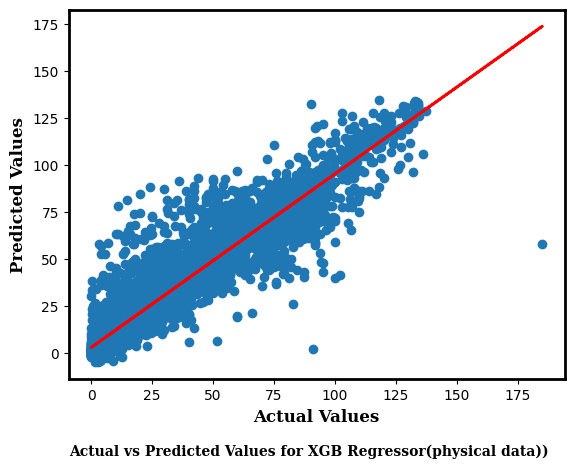

In [ ]:
# Define the XGBoost model
model3 = xgb.XGBRegressor()

# Train the model
model3.fit(X_train, y_train)

# Make predictions on the test set
y_pred3 = model3.predict(X_test)
mse3 = mean_squared_error(y_test, y_pred3)
# Calculate root-mean-squared-error (RMSE)
rmse3 = np.sqrt(mse3)

# Calculate R2 score
r23 = r2_score(y_test, y_pred3)

# Print the results
print(f'Out-of-sample MSE: {mse3:.2f} K')
print(f'Out-of-sample RMSE: {rmse3:.2f} K')
print(f'Out-of-sample R2: {r23:.2f}')
# Plotting actual vs predicted values
#plt.scatter(y_test, y_pred3)
#plt.xlabel('Actual Values')
#plt.ylabel('Predicted Values')
#plt.title('Actual vs Predicted Values for Linear Regression')
#regression_line = np.polyfit(y_test, y_pred3, 1)
#line = np.polyval(regression_line, y_test)
#plt.plot(y_test, line, color='red', linewidth=2)
#plt.show()

# Your code for plotting
plt.scatter(y_test, y_pred3)
plt.xlabel('Actual Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Predicted Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
#plt.title('Actual vs Predicted Values for Linear Regression', fontdict={'fontsize': 14, 'fontweight': 'bold', 'fontfamily': 'serif'})
regression_line = np.polyfit(y_test, y_pred3, 1)
line = np.polyval(regression_line, y_test)
plt.plot(y_test, line, color='red', linewidth=2)
# Add figure name at the base
plt.figtext(0.5, -0.05, 'Actual vs Predicted Values for XGB Regressor(physical data))', ha='center', fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})
# Adjusting the thickness of the axis lines
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Save the figure
# plt.savefig('actual_vs_predicted_XGB_regression.png')

# Show the plot
plt.show()

In [ ]:
import xgboost
print(xgboost.__version__)

2.1.3


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the model with tuned hyperparameters
modelx = xgb.XGBRegressor(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42
)

# Train the model with early stopping
modelx.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True  # This will display training progress
)

# Make predictions on the test set
y_predx = modelx.predict(X_test)

# Calculate errors
mse3 = mean_squared_error(y_test, y_predx)
rmse3 = np.sqrt(mse3)
r23 = r2_score(y_test, y_predx)

print(f'RMSE: {rmse3:.2f}, R2: {r23:.2f}')


[0]	validation_0-rmse:33.25506
[1]	validation_0-rmse:32.45137
[2]	validation_0-rmse:31.69138
[3]	validation_0-rmse:30.94135
[4]	validation_0-rmse:30.22440
[5]	validation_0-rmse:29.51733
[6]	validation_0-rmse:28.83633
[7]	validation_0-rmse:28.18961
[8]	validation_0-rmse:27.55907
[9]	validation_0-rmse:26.94812
[10]	validation_0-rmse:26.38219
[11]	validation_0-rmse:25.81938
[12]	validation_0-rmse:25.29991
[13]	validation_0-rmse:24.76577
[14]	validation_0-rmse:24.25576
[15]	validation_0-rmse:23.76180
[16]	validation_0-rmse:23.28683
[17]	validation_0-rmse:22.82318
[18]	validation_0-rmse:22.37905
[19]	validation_0-rmse:21.94756
[20]	validation_0-rmse:21.52535
[21]	validation_0-rmse:21.12287
[22]	validation_0-rmse:20.73417
[23]	validation_0-rmse:20.36264
[24]	validation_0-rmse:20.00759
[25]	validation_0-rmse:19.66238
[26]	validation_0-rmse:19.33853
[27]	validation_0-rmse:19.02469
[28]	validation_0-rmse:18.71689
[29]	validation_0-rmse:18.42947
[30]	validation_0-rmse:18.16154
[31]	validation_0-

Here we train the three models one without using a hyperparameter and another two with hyperparameters. We can evaluate the model performance by different methods, out of which select RMSE. there are aother ways like R2, MSE, MAE etc.


In [ ]:
# Convert the data to DMatrix format, which is the input format for XGBoost
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost model
params = {
    'objective': 'reg:squarederror',  # Regression task with mean squared error
    'max_depth': 24,
    'learning_rate': 0.35,
    'n_estimators': 1400
}

# Train the XGBoost model
model4 = xgb.train(params, train_data, num_boost_round=10)

# Make predictions on the test set
y_pred4 = model4.predict(test_data)

# Calculate and print the mean squared error
mse4 = mean_squared_error(y_test, y_pred4)
r24 = r2_score(y_test, y_pred4)
rmse4=np.sqrt(mse4)
print(f'Mean Squared Error: {mse4:.2f}')
print(f'Root Mean Squared Error: {rmse4:.2f}')
print(f'R2: {r24:.2f}')

Mean Squared Error: 121.51
Root Mean Squared Error: 11.02
R2: 0.90


In [ ]:

# Define the MLP Regressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred5 = mlp_model.predict(X_test)

# Calculate root-mean-squared-error (RMSE)
rmse5 = np.sqrt(mean_squared_error(y_test, y_pred5))

# Calculate R2 score
r25 = r2_score(y_test, y_pred5)

# Print the results
print(f'Out-of-sample MSE: {mean_squared_error(y_test, y_pred5):.2f}')
print(f'Out-of-sample RMSE: {rmse5:.2f}')
print(f'Out-of-sample R2: {r25:.2f}')

Out-of-sample MSE: 184.22
Out-of-sample RMSE: 13.57
Out-of-sample R2: 0.84


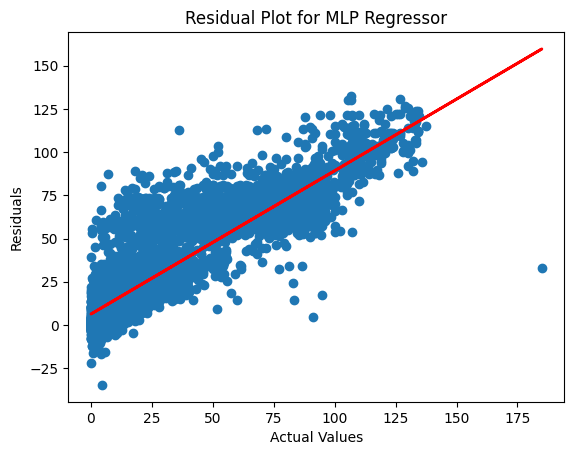

In [ ]:
# Step 6: Calculate residuals
#residuals = y_test - y_pred5

# Step 7: Plot the residuals against the actual values
plt.scatter(y_test, y_pred5)
#plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for MLP Regressor')
regression_line = np.polyfit(y_test, y_pred5, 1)
line = np.polyval(regression_line, y_test)
plt.plot(y_test, line, color='red', linewidth=2)
plt.show()

XGB turn out to be the best model to predict the critical temperature becuase this one works well irrespective of distribution of the data.


In [ ]:
import optuna
def objective(trial):
    # Define the MLP Regressor model with suggested hidden layer sizes
    hidden_layers = trial.suggest_categorical("hidden_layer_sizes", [(50, 100), (100, 100), (50, 75, 100), (25, 50, 75, 100)])
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', random_state=42)

    # Train the model
    mlp_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = mlp_model.predict(X_test)

    # Calculate and return negative R2 score (since Optuna does minimization)
    r2 = r2_score(y_test, y_pred)
    return -r2

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
hidden_layers = best_params["hidden_layer_sizes"]

# Print the best hyperparameters found by Optuna
print('Best Hidden Layer Sizes:', hidden_layers)

# Use the best hyperparameters to train the final model
best_mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', random_state=42)
best_mlp_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_best = best_mlp_model.predict(X_test)

# Calculate and print the final out-of-sample R2 score
mse_final= mean_squared_error(y_test, y_pred_best)
RMSE_final = np.sqrt(mse_final)
final_r2 = r2_score(y_test, y_pred_best)
print(f'Final Out-of-sample mse with Best Model: {mse_final:.2f}')
print(f'Final Out-of-sample rmse with Best Model: {RMSE_final:.2f}')
print(f'Final Out-of-sample R2 with Best Model: {final_r2:.2f}')

[I 2024-12-30 22:34:47,095] A new study created in memory with name: no-name-2cdc3243-872b-4b94-afa5-3e3607fdea85
[I 2024-12-30 22:35:24,688] Trial 0 finished with value: -0.8866361877587595 and parameters: {'hidden_layer_sizes': (50, 75, 100)}. Best is trial 0 with value: -0.8866361877587595.
[I 2024-12-30 22:36:24,876] Trial 1 finished with value: -0.890198838927364 and parameters: {'hidden_layer_sizes': (25, 50, 75, 100)}. Best is trial 1 with value: -0.890198838927364.
[I 2024-12-30 22:37:07,311] Trial 2 finished with value: -0.8886446018938764 and parameters: {'hidden_layer_sizes': (100, 100)}. Best is trial 1 with value: -0.890198838927364.
[I 2024-12-30 22:37:52,419] Trial 3 finished with value: -0.8886446018938764 and parameters: {'hidden_layer_sizes': (100, 100)}. Best is trial 1 with value: -0.890198838927364.
[I 2024-12-30 22:38:31,260] Trial 4 finished with value: -0.8866361877587595 and parameters: {'hidden_layer_sizes': (50, 75, 100)}. Best is trial 1 with value: -0.89019

Best Hidden Layer Sizes: (25, 50, 75, 100)
Final Out-of-sample mse with Best Model: 127.45
Final Out-of-sample rmse with Best Model: 11.29
Final Out-of-sample R2 with Best Model: 0.89


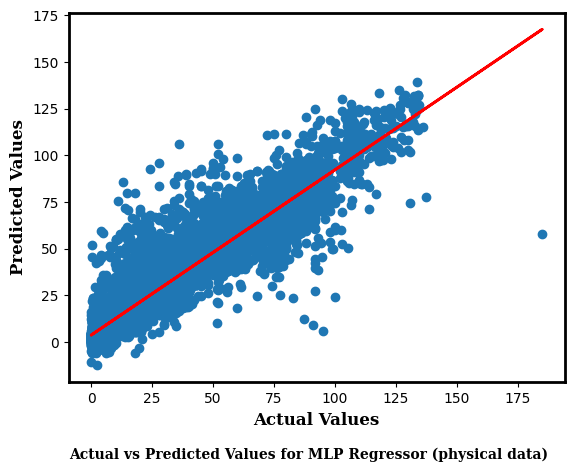

In [ ]:
# Your code for plotting
plt.scatter(y_test, y_pred_best)
plt.xlabel('Actual Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
plt.ylabel('Predicted Values', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
#plt.title('Actual vs Predicted Values for Linear Regression', fontdict={'fontsize': 14, 'fontweight': 'bold', 'fontfamily': 'serif'})
regression_line = np.polyfit(y_test, y_pred_best, 1)
line = np.polyval(regression_line, y_test)
plt.plot(y_test, line, color='red', linewidth=2)
# Add figure name at the base
plt.figtext(0.5, -0.05, 'Actual vs Predicted Values for MLP Regressor (physical data)', ha='center', fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})
# Adjusting the thickness of the axis lines
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Save the figure
plt.savefig('actual_vs_predicted_MLP_regressionp.png')

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold

# Assuming X and y are Pandas DataFrames
# X: DataFrame of shape (21263, 27) with features as columns
# y: DataFrame or Series of shape (21263, ) with the target variable (critical temperature)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for XGBoost
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',  # Use 'hist' for faster computation
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 55),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500)
    }

    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        # Use iloc to select rows correctly
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create DMatrix objects for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train the model
        model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])

        # Predict on the test set
        y_pred = model.predict(dtest)

        # Calculate RMSE for this fold
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        rmse_scores.append(rmse)

    # Return the mean RMSE for all folds
    return np.mean(rmse_scores)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Run for 50 trials (adjust as needed)

# Print the best parameters found by Optuna
print("Best hyperparameters:", study.best_params)


ModuleNotFoundError: No module named 'optuna'

In [ ]:
# Step 3: Train final model on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

# Train the best model on the training set
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Step 4: Make predictions on the holdout test set
y_pred = final_model.predict(X_test)

# Step 5: Calculate RMSE and R² on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the final results
print(f"Best RMSE on holdout test set: {rmse:.4f}")
print(f"Best R² on holdout test set: {r2:.4f}")

Best RMSE on holdout test set: 9.3015
Best R² on holdout test set: 0.9248
